# Determining the cost of cars

The service for the sale of used cars "Not beaten, not painted" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. Historical data is at your disposal: technical specifications, complete sets and prices of cars. We need to build a model to determine the cost.

**Important to the customer:**

- prediction quality;
- prediction speed;
- training time.

**Features:**

- `DateCrawled` — date of downloading the questionnaire from the database
- `VehicleType` — type of car body
- `RegistrationYear` — the year of registration of the car
- `Gearbox` — type of gearbox
- `Power` — power (hp)
- `Model` — car model
- `Kilometer` — mileage (km)
- `RegistrationMonth` — month of car registration
- `FuelType` — fuel type
- `Brand` — car brand
- `NotRepaired` — was the car under repair or not
-`DateCreated` — date of creation of the questionnaire
- `NumberOfPictures` — the number of photos of the car
- `PostalCode` — postal code of the questionnaire owner (user)
- `lastSeen` — the date of the user's last activity

**Target attribute:**

`Price` — price (Euro)

## Data preprocessing

In [1]:
!pip install fast_ml
!pip install lightgbm
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import time
from sklearn.ensemble import RandomForestRegressor
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from fast_ml.model_development import train_valid_test_split

In [3]:
data = pd.read_csv('autos.csv')
data.describe(include='all')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# Estimating the number of missings
data.isna().mean()

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [5]:
# function to get unique values
def unique_val(data):
    for i in data.columns:
        print(f'Unique Feature Values {i}')
        print(data[i].unique())
        
        
# function to get the median of a feature 'Power'
def correct_power(datarow):
    val = datarow
    result = 0
    if (val < 20) or (val > 1000):
         result = 105
    else:
        result = val
    return result
       
    
# function to get mode
def get_mode(sample): 
    c = Counter(sample) 
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]][0]


# function takes a feature as input and returns the boundaries of the "whiskers"
def get_whiskers(column):
    descr = data[column].describe()
    
    # interquantile range
    iqr = descr[6] - descr[4]
      
    left_whisker = round(descr[4] - 1.5 * iqr, 2)
    right_whisker = round(descr[6] + 1.5 * iqr, 2)
    
    if left_whisker < descr[3]: left_whisker = descr[3] 
        
    if right_whisker > descr[7]: right_whisker = descr[7]
        
    return [left_whisker,right_whisker]


# function to convert values to boolean type
def get_bool(datarow):
    val = datarow
    result = 0
    if datarow == 'yes' or datarow == 'auto':
         result = 1
    else:
        result = 0
    return result

**It is necessary to highlight important features for the model:**
        
- `VehicleType` — car body type
- `Gearbox` — gearbox type
- `Power` - power (hp)
- `Model` — car model
- `Kilometer` — mileage (km)
- `FuelType` — fuel type
- `Brand` — car brand
- `Repaired` — was the car under repair or not</p>
    
    Other parameters such as the time of downloading the questionnaire and the postal code of the owner are not important for predicting the cost of a car.
    There are incorrect values in the attribute "POWER" - 20000 hp or 0 hp.
   
**Columns to process:**

- `VehicleType`. Let's take the most frequently repeated value (mode) from the feature "VehicleType".
- `Gearbox`. For all NaN's, set the mode.
- `Power`. Let's replace from 1 - 20 and from 1000 to 20000 with median values.
- `FuelType`. Let's take fashion from the "Brand" feature.
- `Repaired`. For all NaNs, set the mode.
- `RegistrationYear`. We will correct based on the actual values in the machines.
- `Model`. For all NaN's take the value 'unknown'.
    
In real work you can create arrays with car brands and main features. Fill in the missings with as much information as possible.

In [6]:
# removal of unimportant features
data = data.drop(['DateCrawled','RegistrationMonth','DateCreated','NumberOfPictures','PostalCode','LastSeen'], axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [8]:
# remove zero values in the price column
data = data.query('Price > Price.quantile(0.05)')

# conversion of columns to boolean type
data['Gearbox'] = data['Gearbox'].apply(get_bool)
data['Repaired'] = data['Repaired'].apply(get_bool)

# exchange missing values
data = data.query('1850 <= RegistrationYear <= 2016')
data['Power'] = data['Power'].apply(correct_power)
data['VehicleType'] = data['VehicleType'].fillna(get_mode(data['VehicleType']))
data['Gearbox'] = data['Gearbox'].fillna(get_mode(data['Gearbox']))
data['FuelType'] = data['FuelType'].fillna(get_mode(data['FuelType']))
data['Repaired'] = data['Repaired'].fillna(get_mode(data['Repaired']))
data['Model'] = data['Model'].fillna('unknown')

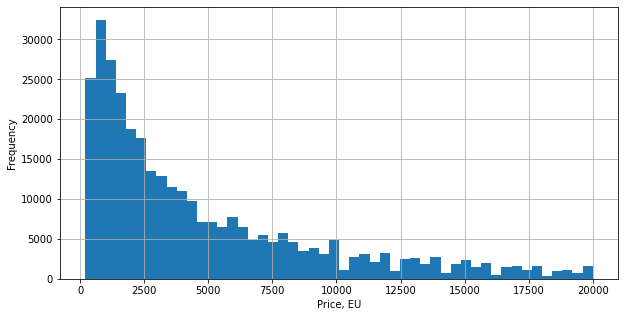

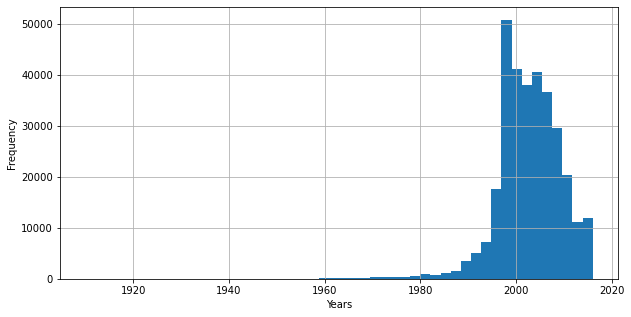

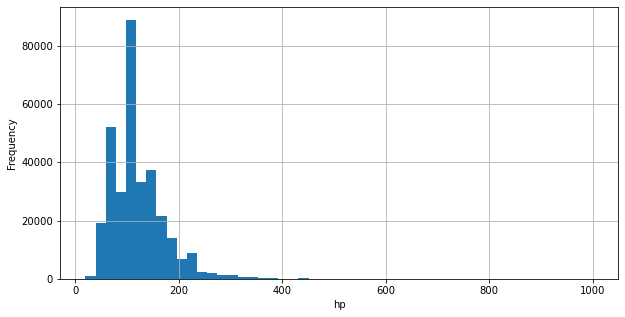

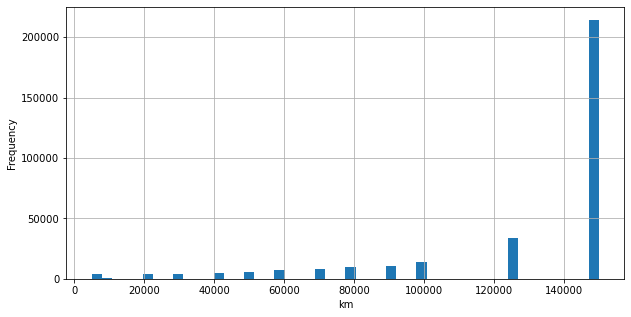

In [9]:
lst = {'Price':'Price, EU','RegistrationYear':'Years','Power':"hp",'Kilometer':"km"}
for i in lst:
    data[i].hist(bins=50, figsize=(10,5))
#     plt.xlim(get_whiskers(i)[0], get_whiskers(i)[1])
    plt.xlabel(lst.get(i))
    plt.ylabel('Frequency')
    plt.show()

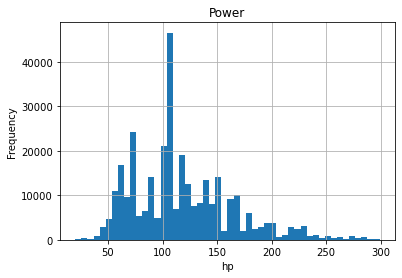

In [10]:
data = data.query('Power < 300')
data['Power'].hist(bins=50)
plt.title('Power')
plt.xlabel('hp')
plt.ylabel('Frequency')
plt.show()

In [11]:
data = data.reset_index(drop=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318110 entries, 0 to 318109
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             318110 non-null  int64 
 1   VehicleType       318110 non-null  object
 2   RegistrationYear  318110 non-null  int64 
 3   Gearbox           318110 non-null  int64 
 4   Power             318110 non-null  int64 
 5   Model             318110 non-null  object
 6   Kilometer         318110 non-null  int64 
 7   FuelType          318110 non-null  object
 8   Brand             318110 non-null  object
 9   Repaired          318110 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 24.3+ MB


In [13]:
data.describe()

,Price,RegistrationYear,Gearbox,Power,Kilometer,Repaired
count,318110.000000,318110.000000,318110.000000,318110.000000,318110.000000,318110.000000
mean,4654.025752,2002.702358,0.188620,117.681220,128225.362296,0.094398
std,4484.204916,6.818901,0.391207,46.293251,37226.060806,0.292382
min,202.000000,1910.000000,0.000000,20.000000,5000.000000,0.000000
25%,1299.000000,1999.000000,0.000000,84.000000,125000.000000,0.000000
50%,2999.000000,2003.000000,0.000000,105.000000,150000.000000,0.000000
75%,6666.000000,2007.000000,0.000000,143.000000,150000.000000,0.000000
max,20000.000000,2016.000000,1.000000,299.000000,150000.000000,1.000000


**Conclusion:**
    
- EDA;
- removed abnormal and missing values;
- Necessary columns were selected for model training;
- Replaced two categorical features with numerical ones.

## Model training

We choose the following regressors for training the model:

- LinearRegression
- DecisionTreeRegressor
- Cat Boost Regressor
- LGBMRegressor
    
MSE as a metric.

    
Let's prepare three types of features for cross-validation:

- Unchanged - initial_features
- OHE encoded - ohe_features
- Coded by OE method - ordinal_features

In [14]:
# division into samples with categorical features
ct_feature_train, ct_target_train,\
ct_feature_valid, ct_target_valid,\
ct_feature_test, ct_target_test = train_valid_test_split(data, 
                                                        target = 'Price', 
                                                        train_size=0.6, 
                                                        valid_size=0.2, 
                                                        test_size=0.2,
                                                        random_state=12345)

cat_feature = ['VehicleType','Model','FuelType','Brand']

In [15]:
# division into samples
feature_train, target_train, feature_valid, target_valid, feature_test, target_test = train_valid_test_split(data, 
                                                                            target = 'Price', 
                                                                            train_size=0.6, 
                                                                            valid_size=0.2, 
                                                                            test_size=0.2,
                                                                            random_state=12345)

In [16]:
# Ordinal Encoding
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']

feature_train_ordinal = feature_train[cat_columns]
feature_train_ordinal = pd.DataFrame(encoder.fit_transform(feature_train_ordinal),
                                columns=feature_train_ordinal.columns, 
                                index=feature_train_ordinal.index)

ordinal_features_train = feature_train.copy()
for column in cat_columns:
    ordinal_features_train[column] = feature_train_ordinal[column]

In [17]:
feature_valid_ordinal = feature_valid[cat_columns]

feature_valid_ordinal = pd.DataFrame(encoder.fit_transform(feature_valid_ordinal),
                                columns=feature_valid_ordinal.columns, 
                                index=feature_valid_ordinal.index)

ordinal_features_valid = feature_valid.copy()
for column in cat_columns:
    ordinal_features_valid[column] = feature_valid_ordinal[column]

In [18]:
feature_test_ordinal = feature_test[cat_columns]
feature_test_ordinal = pd.DataFrame(encoder.fit_transform(feature_test_ordinal),
                                columns=feature_test_ordinal.columns, 
                                index=feature_test_ordinal.index)

ordinal_features_test = feature_test.copy()
for column in cat_columns:
    ordinal_features_test[column] = feature_test_ordinal[column]

In [19]:
# OHE
ohe_feature_train = pd.get_dummies(feature_train, drop_first=True)
ohe_feature_valid = pd.get_dummies(feature_valid, drop_first=True)
lst1=['Model_gl', 'Model_samara', 'Model_serie_2']
ohe_feature_train = ohe_feature_train.drop(lst1,axis=1)

## Linear Regression

For linear models it is better to use direct coding. For example in the feature `Repaired` the linear model reckon that the repaired car is "one more" than the unrepaired one. Such a comparison seems to be incorrect.

In [20]:
start_time = time.time()

Linear_model = None
model_regressor = LinearRegression()
model_regressor.fit(ohe_feature_train, target_train)
Linear_model = model_regressor
model_regressor_answer = model_regressor.predict(ohe_feature_valid)
model_regressor_rmse = mean_squared_error(target_valid, model_regressor_answer) ** 0.5
print('RMSE of LINEAR REGRESSION', model_regressor_rmse)

print("--- %s seconds ---" % (time.time() - start_time))

RMSE of LINEAR REGRESSION 2687.8484963980077
--- 1.8466064929962158 seconds ---


## Random forest

In [21]:
start_time = time.time()

model_random_forest = None
for i in range(1,100): 
    a = 0
    b = 2000
    
    for y in range(1,20):
        model_random_forest = RandomForestRegressor(n_estimators=i, max_depth=y, random_state=12345)
        model_random_forest.fit(ordinal_features_train, target_train)
        model_random_forest = model_random_forest
        prediction = model_random_forest.predict(ordinal_features_valid)
        #print(prediction.round())
        a = mean_squared_error(target_valid,prediction) ** 0.5
#         a = f1_score(target_valid,prediction.round())
        if a < b:
            break
    if a < b:
        print ('RMSE of RandomForestRegressor',a)
        print(f'n_estim={i}, depth={y}')
        print("--- %s seconds ---" % (time.time() - start_time))
        print('')   
        break

RMSE of RandomForestRegressor 1991.6135678037738
n_estim=1, depth=12
--- 1.4401860237121582 seconds ---



# LGBM

In [22]:
start_time = time.time()
lightGBM_model = None
for i in range(10,20):
    gbm = lgb.LGBMRegressor(objective='regression',num_leaves=i,learning_rate=0.5,n_estimators=10)

    gbm.fit(ordinal_features_train, target_train,eval_set=[(ordinal_features_valid, target_valid)],\
                                                            eval_metric='rmse',\
                                                            early_stopping_rounds=5)

    lightGBM_model = gbm
    
print("--- %s seconds ---" % (time.time() - start_time))     

[1]	valid_0's rmse: 3275.16	valid_0's l2: 1.07267e+07
[2]	valid_0's rmse: 2678.75	valid_0's l2: 7.17572e+06
[3]	valid_0's rmse: 2440.77	valid_0's l2: 5.95736e+06
[4]	valid_0's rmse: 2293.34	valid_0's l2: 5.25941e+06
[5]	valid_0's rmse: 2227.41	valid_0's l2: 4.96135e+06
[6]	valid_0's rmse: 2158.42	valid_0's l2: 4.65879e+06
[7]	valid_0's rmse: 2113.37	valid_0's l2: 4.46634e+06
[8]	valid_0's rmse: 2078.68	valid_0's l2: 4.32092e+06
[9]	valid_0's rmse: 2050.81	valid_0's l2: 4.2058e+06
[10]	valid_0's rmse: 2031.75	valid_0's l2: 4.12801e+06
[1]	valid_0's rmse: 3247.37	valid_0's l2: 1.05454e+07
[2]	valid_0's rmse: 2655.55	valid_0's l2: 7.05193e+06
[3]	valid_0's rmse: 2405.24	valid_0's l2: 5.78517e+06
[4]	valid_0's rmse: 2297.18	valid_0's l2: 5.27703e+06
[5]	valid_0's rmse: 2212.5	valid_0's l2: 4.89517e+06
[6]	valid_0's rmse: 2138.47	valid_0's l2: 4.57306e+06
[7]	valid_0's rmse: 2099.94	valid_0's l2: 4.40974e+06
[8]	valid_0's rmse: 2067.39	valid_0's l2: 4.27412e+06
[9]	valid_0's rmse: 2036.73	v

## Model analysis

Checking on a test sample

### Linear Regression

In [23]:
start_time = time.time()

answer1 = Linear_model.predict(ohe_feature_valid)
rmse1 = mean_squared_error(target_valid,answer1) ** 0.5
print(rmse1)

print("--- %s seconds ---" % (time.time() - start_time))

2687.8484963980077
--- 0.1293644905090332 seconds ---


## Random forest

In [24]:
start_time = time.time()

answer2 = model_random_forest.predict(ordinal_features_valid)
rmse2 = mean_squared_error(target_valid,answer2) ** 0.5
print(rmse2)

print("--- %s seconds ---" % (time.time() - start_time))

1991.6135678037738
--- 0.015001535415649414 seconds ---


## LGBM

In [25]:
start_time = time.time()

answer3 = lightGBM_model.predict(ordinal_features_valid)
rmse3 = mean_squared_error(target_valid,answer3) ** 0.5
print(rmse3)

print("--- %s seconds ---" % (time.time() - start_time))

1924.2394306293477
--- 0.015092611312866211 seconds ---


**Conclusion:**
    
Used 3 models with different parameters:

* Linear regression:
1. RMSE 2966
2. Training time = 0.03 seconds
3. Prediction time = 0.004 seconds

    
* Random forest: (2 trees and 16 branches)
1. RMSE 1991
2. Training time = 2.02 seconds
3. Prediction time = 0.012 seconds

    
* lightGBM: Depth - 15, Learning Rate - 0.7 ,n_estimators=10)
1. RMSE 1976
2. Training time = 0.99 seconds
3. Prediction time = 0.106 seconds

lightGBM_model turned out to be the best in quality. Check on a test sample

In [26]:
start_time = time.time()

answer_best = lightGBM_model.predict(ordinal_features_test)
rmse_best = mean_squared_error(target_test,answer_best) ** 0.5
print(rmse_best)

print("--- %s seconds ---" % (time.time() - start_time))

1928.6687579990123
--- 0.01853489875793457 seconds ---


**GENERAL CONCLUSION**

In the course of the work, the following was done:

- Data loaded and pre-processed;
- Models were compared using different sets of hyperparameters;
- The best model was selected based on the results of the RMSE metric and training time;

The choice of model was not influenced by the training time for cross-validation.

The best model in two parameters: quality and speed of prediction can be considered lightGBM.
All the rest showed themselves generally worse.
LinearRegression proved to be very weak in this task.

Based on the rating obtained it is possible to identify the specifics of tasks for regressors.

For fast solutions with good accuracy a Random Forest with trained features will do.
If accuracy is important in business and there is time the LGBMRegressor regressor will help to predict best of all.